## Part 2A: Discrete shape analysis

In this notebook, we will learn the basics of shape analysis on landmarked data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
plt.rcParams['figure.dpi'] = 200

### 0. Data loading

**0.1** Run the lines below to load point-based object models of objects in the C. elegans dataset.

*The C. elegans dataset is presented and prepared in notebook 1 - Data preparation.*

In [3]:
dataset='data/C. elegans/point_models.npy'
point_models=np.load(dataset)

In [4]:
# The number of points in our object model is an important parameter
N=point_models.shape[1]
print("N="+str(N))

N=12


**0.2** Run the lines below to visualize a set of a few randomly selected models from the collection.

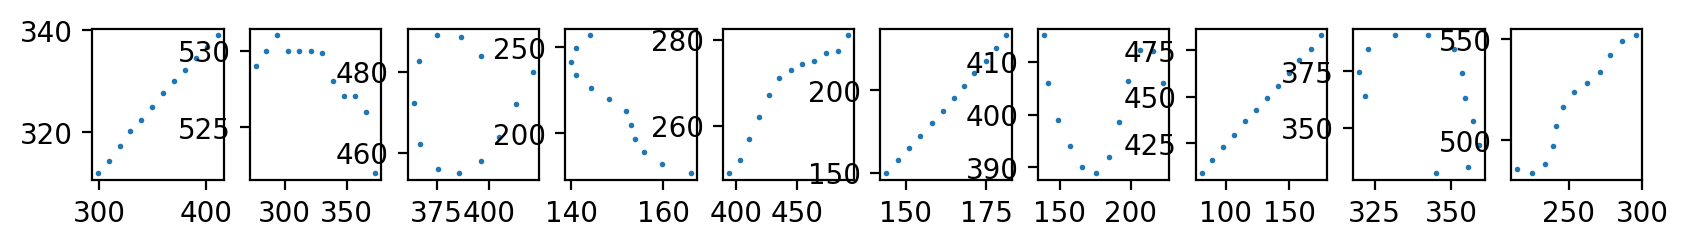

In [5]:
number=10
inds=np.random.choice(len(point_models)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(number):
    point_model=np.array(point_models[inds[i]])
    ax[i].scatter(point_model[:,0],point_model[:,1],s=1)

### 1. Procrustes alignment

**1.1** Center and scale the data such that they are all located around (0,0) and are of unit norm. Object models normalized in this way are referred to as preshapes.

*Hint: use ``np.linalg.norm`` to normalize*

In [6]:
# Solution:
preshapes=np.zeros(point_models.shape)

for i in range(len(point_models)):
    point_model=point_models[i]
    
    centroid=np.mean(point_model,0)
    centered=point_model-centroid
    
    scaled=centered/np.linalg.norm(centered)
    preshapes[i]=scaled

**1.2** Write an objective function to align one object model onto another one, assuming that the two models are in correspondence†. This problem can be formulated as finding the rotation angle that minimizes the root mean square error (RMSE) between the two point sets.

*Hint 1: assuming the distance between two models is ``L``, the RMSE is given as ``np.sqrt(np.mean(L**2))``.*

*Hint 2: rotating a point set can be done by multiplying with a 2D rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix).*

† Bonus question: do you understand what this assumption means? Which step must be performed when building the object models to ensure that it holds?

In [7]:
import scipy.optimize

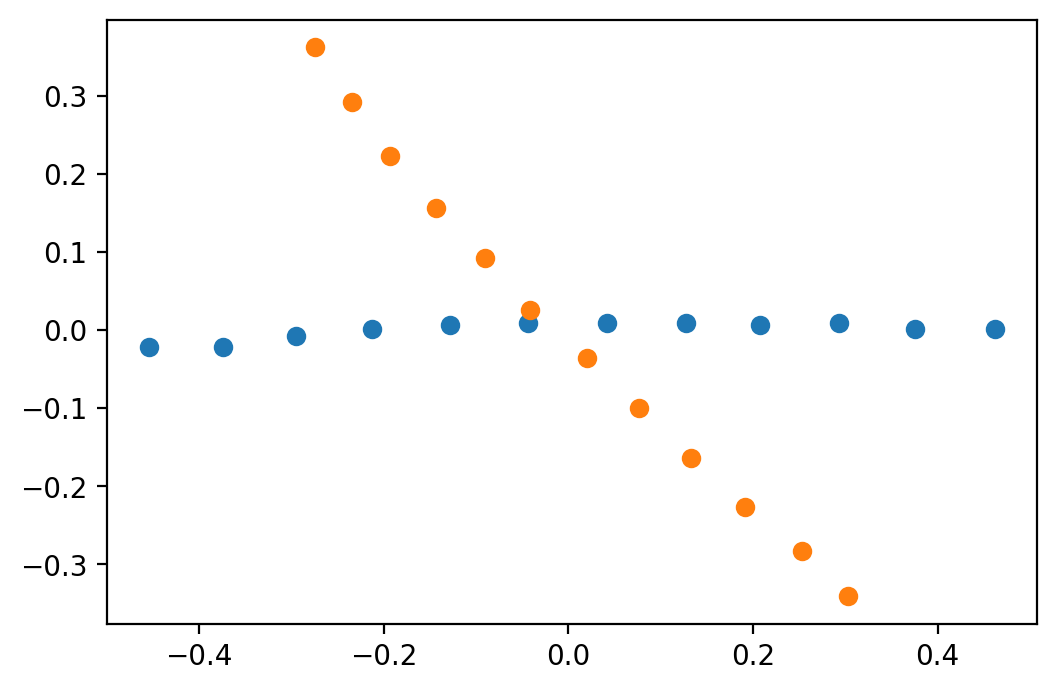

In [8]:
# Picks two random models - reload if you are not happy with the selection :)
random=np.random.choice(len(point_models)-1, size=2, replace=False)

sample_preshape_1=preshapes[random[0]]
sample_preshape_2=preshapes[random[1]]

plt.scatter(sample_preshape_1[:,0],sample_preshape_1[:,1])
plt.scatter(sample_preshape_2[:,0],sample_preshape_2[:,1])
plt.show()

In [9]:
# Solution:
def objectiveFunctionAlignment(theta, m1, m2):
    R=np.array([[np.cos(theta[0]),-np.sin(theta[0])],[np.sin(theta[0]),np.cos(theta[0])]])
    rotated_m2=(R@m2.T).T
    error=np.linalg.norm(m1-rotated_m2)
    rmse=np.sqrt(np.mean(error**2))
    return rmse

In [10]:
# Optimizes the objective function
res=scipy.optimize.minimize(objectiveFunctionAlignment,0,args=(sample_preshape_1,sample_preshape_2),method="L-BFGS-B")
theta0=res.x[0]
print(theta0)

0.8972127687286366


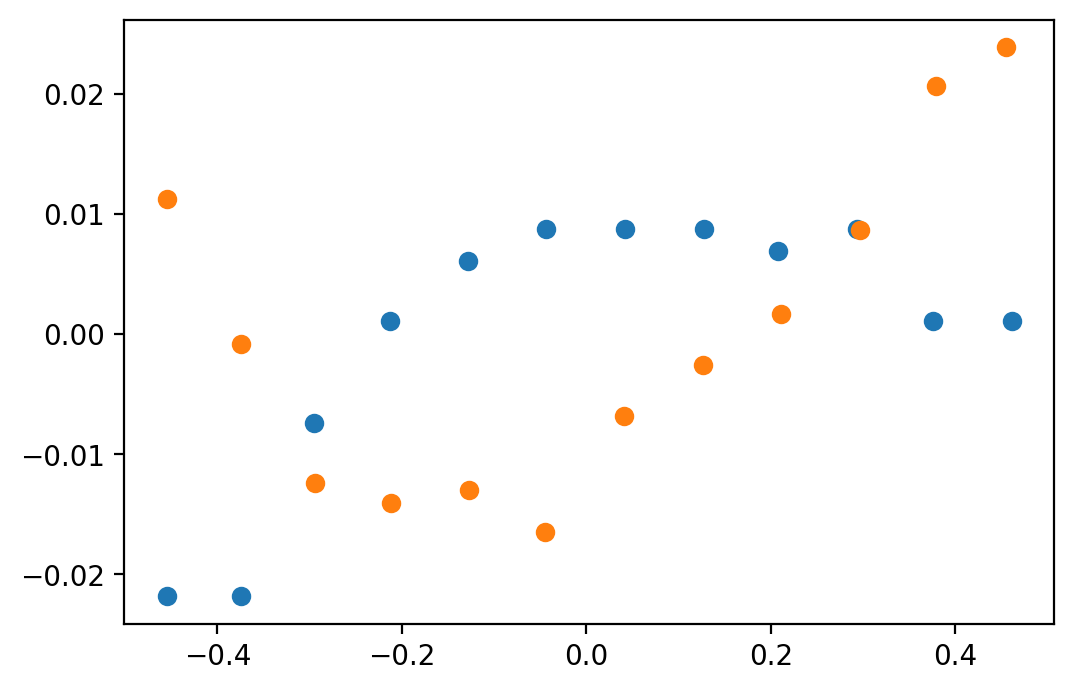

In [11]:
# Visualizes the alignment
plt.scatter(sample_preshape_1[:,0],sample_preshape_1[:,1])

R=np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])
aligned=(R@sample_preshape_2.T).T

plt.scatter(aligned[:,0],aligned[:,1])
plt.show()

**1.3** Object models in 2D can be seen as vectors of complex numbers associated with an appropriate Hermitian inner product. The lines below transforms your two objects into complex vectors. Run the lines below to convince yourself that the "vector of complex numbers" representation is equivalent to the "vector of points" one.

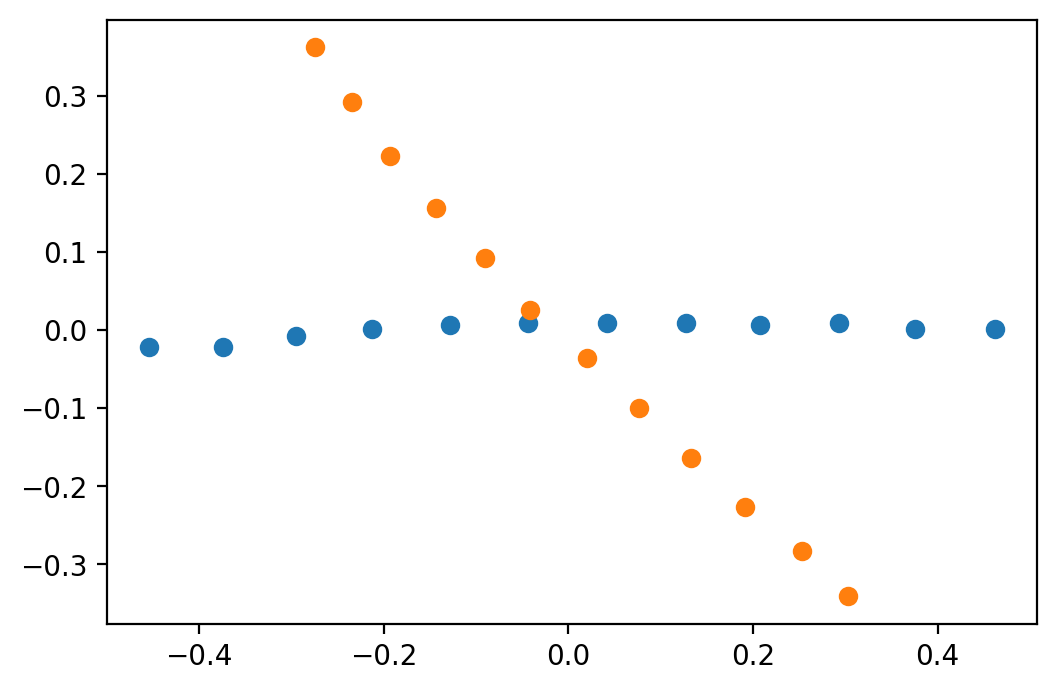

In [12]:
complex_sample_preshape_1=sample_preshape_1[:,0]+1j*sample_preshape_1[:,1]
complex_sample_preshape_2=sample_preshape_2[:,0]+1j*sample_preshape_2[:,1]

plt.scatter(complex_sample_preshape_1.real,complex_sample_preshape_1.imag)
plt.scatter(complex_sample_preshape_2.real,complex_sample_preshape_2.imag)
plt.show()

**1.4** The solution of the optimal alignment problem 1.2 can actually be expressed in closed-form when relying on complex representations, bypassing the need for an optimization. Run the lines below to verify that you obtain the same solution as in 1.2 (and be amazed by the beauty of maths :)).

In [13]:
theta0_complex=np.angle(complex_sample_preshape_2.conj().T @ complex_sample_preshape_1)
print(theta0_complex)

0.8972130125655353


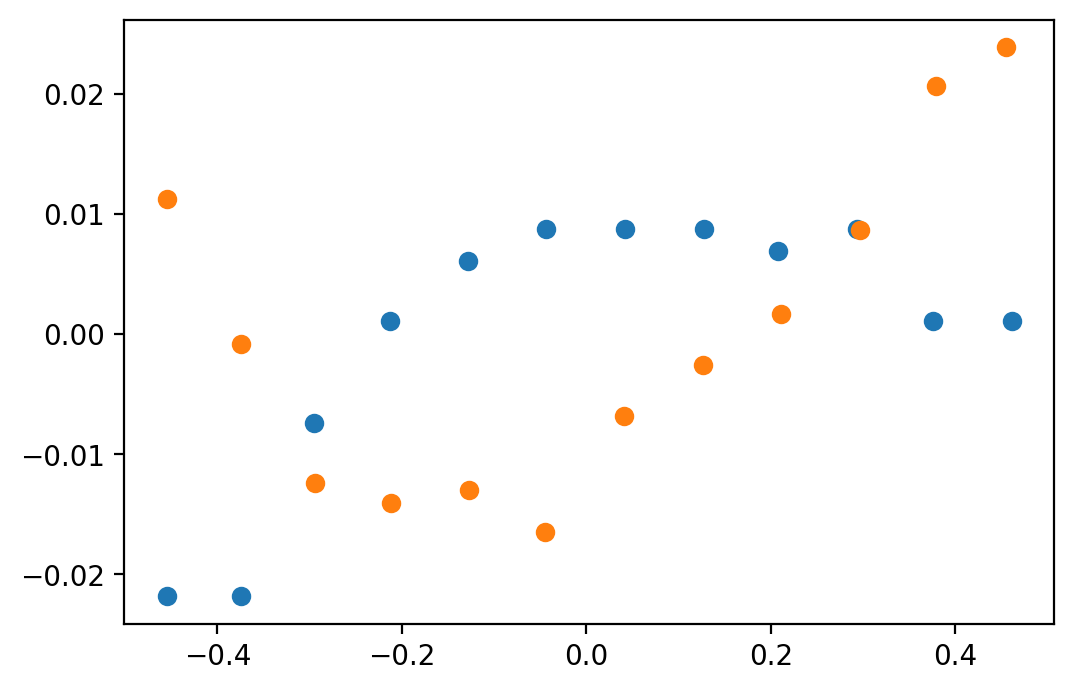

In [14]:
# Visualizes the alignment 
plt.scatter(complex_sample_preshape_1.real,complex_sample_preshape_1.imag)

aligned_complex=np.exp(1j*theta0_complex)*complex_sample_preshape_2

plt.scatter(aligned_complex.real,aligned_complex.imag)
plt.show()

### 2. Kendall shape space

**2.1** To build the shape space, we will rely on the complex representation introduced in 1.3. Convert your whole collection of preshapes (obtained in 1.1) into complex numbers. 

*Important note: Make sure that complex_preshapes is a numpy array!*

In [15]:
# Solution
complex_preshapes=preshapes[:,:,0] + 1j*preshapes[:,:,1]

**2.2** The function below computes the Fréchet mean of a dataset relying on complex number representations. Use it to extract the Fréchet mean of your dataset and visualize it.

In [16]:
def meanFrechet(input_complex_preshapes): # preshapes
    '''Input: dataset of complex preshapes.
    Output: Fréchet mean (w.r.t. the Procrustes distance).'''
    SQ = input_complex_preshapes.T @ input_complex_preshapes.conj()
    D,V = np.linalg.eig(SQ)
    ds = np.real(D)
    ind_max = np.argmax(ds)
    ds_max = np.max(ds)
    m = V[:,ind_max]
    
    centered_m=m-np.mean(m)
    m_norm=np.sqrt(centered_m.conj().T @ centered_m).real
    return m/m_norm

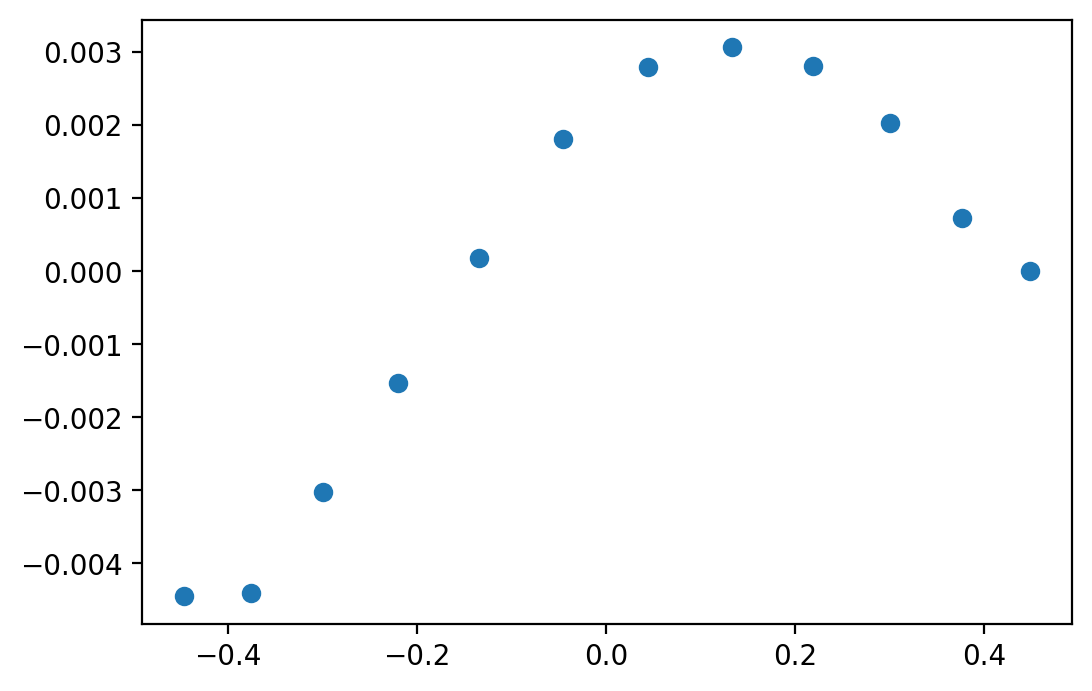

In [17]:
# Solution:
mean_shape_Frechet=meanFrechet(complex_preshapes)
plt.scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
plt.show()

**2.3** Using the alignment procedure introduced in 1.4, align each element of the dataset onto the Fréchet mean (computed in 2.2).

In [18]:
# Solution:
complex_aligned_shapes=np.zeros(complex_preshapes.shape, dtype=complex)

for i in range(len(complex_preshapes)):
    theta=np.angle(complex_preshapes[i].conj().T @ mean_shape_Frechet)
    complex_aligned_shapes[i] = np.exp(1j*theta)*complex_preshapes[i]
    
    # Use this one to retrieve the geometrical mean (scaling with alignment)
    #complex_aligned_shapes[i] = (complex_preshapes[i].conj().T @ mean_shape_Frechet)*complex_preshapes[i]

**2.4** Now that all shapes are aligned, compute the (point-by-point) mean shape of the dataset and visualize it. Does it differ from what you got in 2.2?

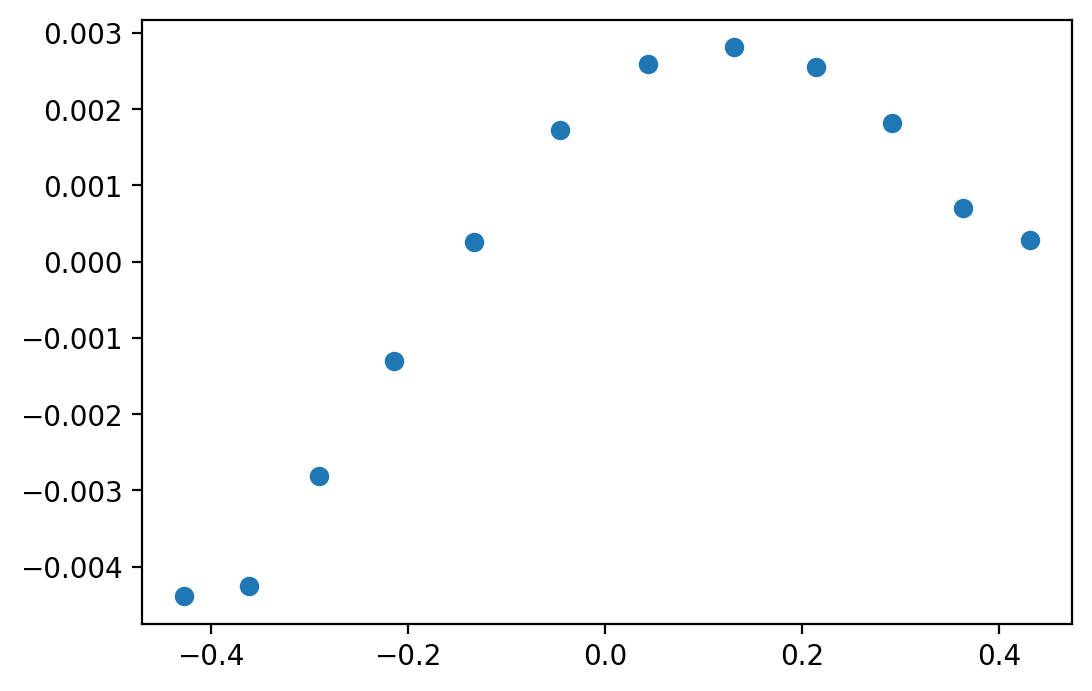

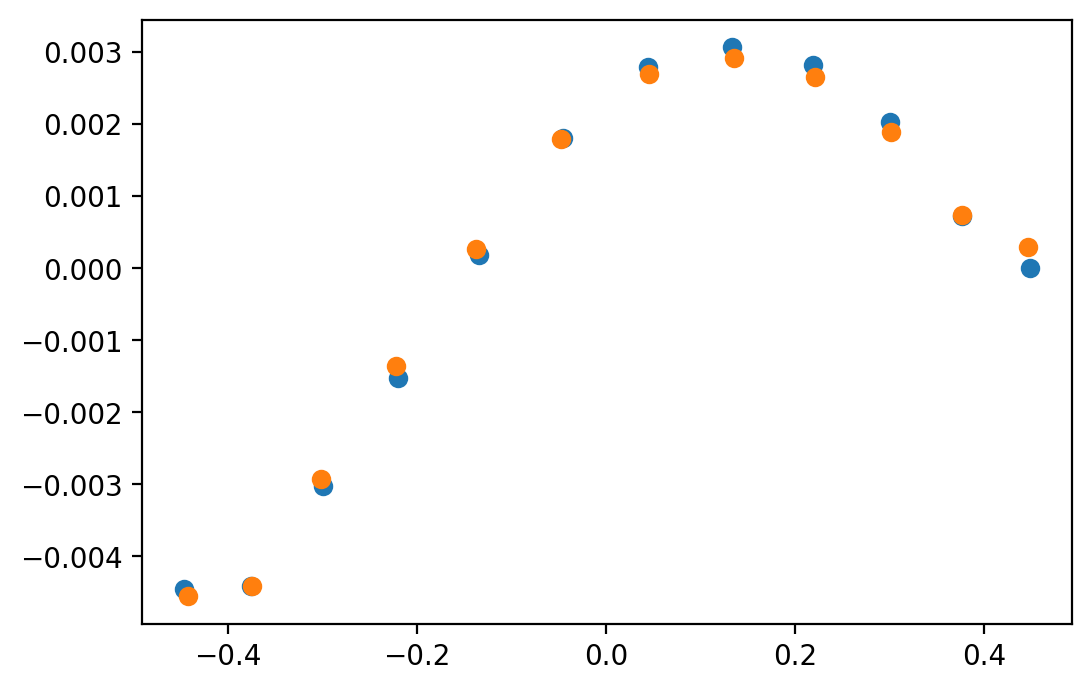

In [19]:
# Solution:
mean_shape=np.mean(complex_aligned_shapes,0)

fig, ax = plt.subplots(1,1)
ax.scatter(mean_shape.real,mean_shape.imag)
plt.show()

# It is equal to the Fréchet mean, up to a scaling factor
fig, ax = plt.subplots(1,1)
ax.scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)

mean_shape_c=mean_shape-np.mean(mean_shape)
mean_shape_norm=mean_shape_c/np.sqrt(mean_shape_c.conj().T @ mean_shape_c).real
ax.scatter(mean_shape_norm.real,mean_shape_norm.imag)
plt.show()

**2.5** The code below and retreives the mean shape of the dataset relying on general Procrustes alignment. Run it a few times: what do you observe? Does the mean shape obtained in this way differ from what you got in 2.4? 

*As a reminder, general Procrustes alignment  the following iterative procedure:*
1. *Randomly select one object from the collection*
2. *Align every other objects to it (ordinary Procrustes alignment)*
3. *Compute the average of all aligned data points and scale it to unit norm*
4. *Align all objects to that new average*
5. *Compute the average of all aligned data (not considering the average obtained at step 3 as this is not part of the data!)*
6. *Repeat steps 4 and 5 until convergence*

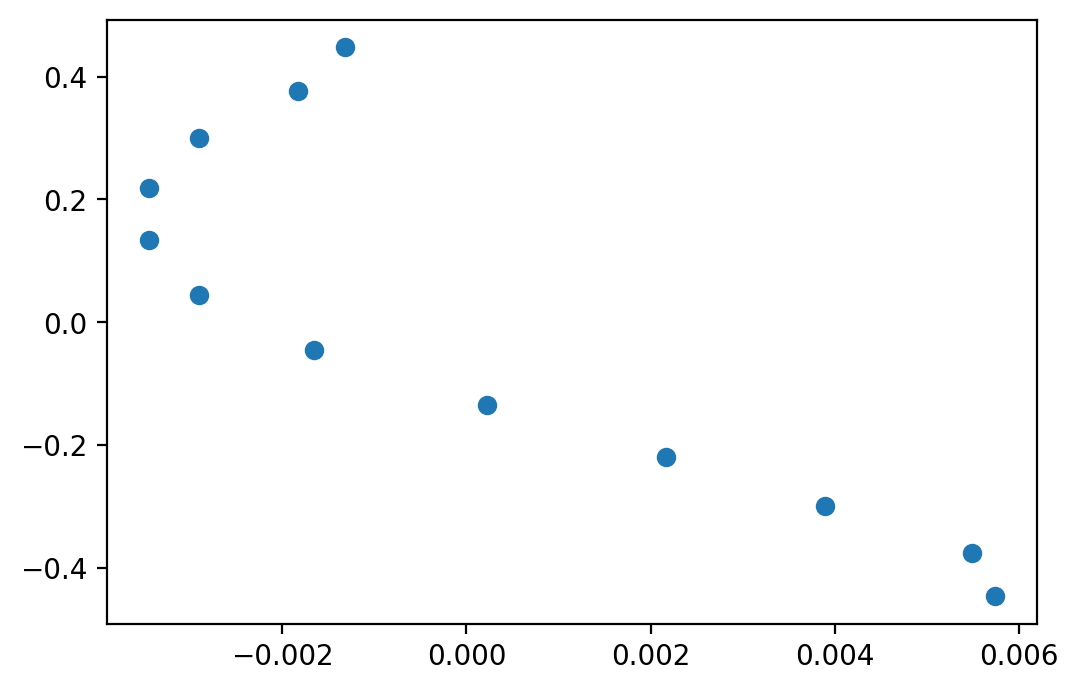

In [20]:
from copy import deepcopy

# 1. Randomly select one object from the collection
random=np.random.randint(len(complex_preshapes)-1)
complex_reference=complex_preshapes[random]

# 2. Align every other objects to it (ordinary Procrustes alignment)
aligned_complex=np.zeros(complex_preshapes.shape, dtype=complex)
for i in range(len(complex_preshapes)):
    aligned_complex[i]=(complex_preshapes[i].conj().T @ complex_reference)*complex_preshapes[i]
    
# 3. Compute the average of all aligned data points and scale it to unit norm
mean_shape_2=np.mean(aligned_complex,0)
mean_shape_2/=np.linalg.norm(mean_shape_2)

epsilon = 1e-3
delta = np.Inf
while np.abs(delta) > epsilon:
    # 4. Align all objects to that new average
    aligned_complex=np.zeros(complex_preshapes.shape, dtype=complex)
    for i in range(len(complex_preshapes)):
        aligned_complex[i]=(complex_preshapes[i].conj().T @ mean_shape_2)*complex_preshapes[i]

    # 5. Compute the average of all aligned data (not considering the average obtained at step 3 as this is not part of the data!)
    new_mean_shape_2=np.mean(aligned_complex,0)
    new_mean_shape_2/=np.linalg.norm(new_mean_shape_2)

    # 6. Repeat steps 4 and 5 until convergence
    delta=np.linalg.norm(new_mean_shape_2 - mean_shape_2)
    mean_shape_2=deepcopy(new_mean_shape_2)

# Visualize the result
plt.scatter(mean_shape_2.real,mean_shape_2.imag)
plt.show()
# The nature of the mean shape changes depending on the initial reference and 
# it is completely different from the Fréchet mean!


**2.6** Relying on the function ``geodesicPath`` below, compute the geodesic path between a randomly picked shape in the dataset and the Fréchet mean, and visualize elements along the path.

In [54]:
def geodesicDistance(z,w): 
    '''Geodesic distance between [z] and [w].'''
    aux=np.abs(z.conj().T @ w)
    if aux>1.0: 
        aux=1.0
    return np.arccos(aux)

def geodesicPath(z,w,numSteps): 
    '''Returns elements regularly spaced along the geodesic curve joining z to w (preshapes).'''
    ro = geodesicDistance(z,w)
    steps = np.arange(numSteps+1)/numSteps

    ta = np.angle(z.conj().T @ w)
    path = 1/np.sin(ro)*(np.sin((1-steps[:,None])*ro)*np.exp(1j*ta)*z + np.sin(steps[:,None]*ro)*w)
    return path

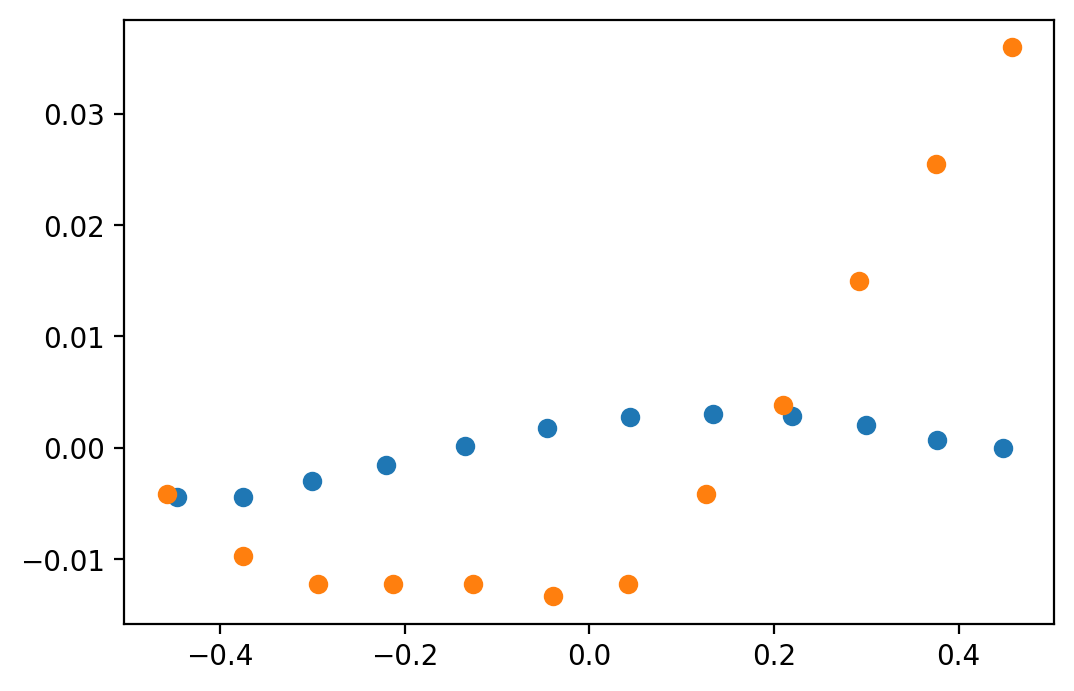

In [55]:
# Picks one random complex preshape and visualize it with the Fréchet mean - reload if you are not happy with the selection :)
random=np.random.choice(len(complex_preshapes)-1, size=1, replace=False)[0]
sample_preshape=complex_preshapes[random]

plt.scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
plt.scatter(sample_preshape.real,sample_preshape.imag)
plt.show()

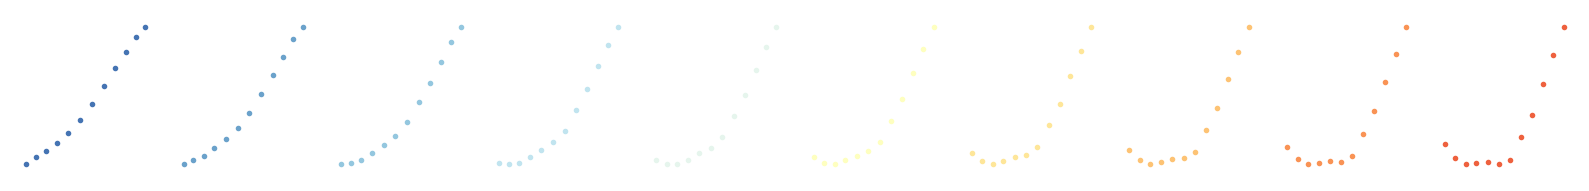

In [56]:
# Solution:
# Compute N steps along the geodesic path
steps=10
path=geodesicPath(mean_shape_Frechet,sample_preshape,steps)

fig, ax = plt.subplots(1,steps, figsize=(steps,1))
colors = cm.RdYlBu(np.linspace(0.9, 0.1, len(path)))
for i in range(steps):
    ax[i].scatter(path[i].real,path[i].imag, s=1, color=colors[i])
    ax[i].axis('off')

**2.7** Compare the length of the above geodesics with the Procrustes distance (the distance you used for the alignment in 1.2). What do you observe? Can you relate that to what you know about the nature of the shape space?

In [24]:
# Solution:
geo_distance=geodesicDistance(sample_preshape,mean_shape_Frechet)
print("Geodesic distance: "+str(geo_distance))

procrustes_dist=np.linalg.norm(complex_aligned_shapes[random]-mean_shape_Frechet)
print("Procrustes distance: "+str(procrustes_dist))

Geodesic distance: 0.031067797322506863
Procrustes distance: 0.031066547883938516


**2.8** Compare the Procrustes distance (the distance you used for the alignment in 1.2) with the chord distance on the shape space defined below. What do you observe?

In [25]:
def chordDistance(z,w): # preshapes
    '''Chord distance between [z] and [w].'''
    return np.sqrt(1.0 - np.abs(z.conj().T @ w)**2)

In [26]:
# Solution:
chord_distance=chordDistance(sample_preshape,mean_shape_Frechet)
print("Geodesic distance: "+str(chord_distance))
print("Procrustes distance: "+str(procrustes_dist))

Geodesic distance: 0.03106279974911961
Procrustes distance: 0.031066547883938516


### 3. Shape space PCA on the whole dataset

A classical trick to perform local linear operations on a Riemannian manifold is to rely on local tangent spaces. The way into and out of the tangent space are the logarithm and exponential maps, respectively. Their expression for the shape space of point-based models we are currently working with are provided below.

In [27]:
def logarithmMap(z,w): 
    '''Computes a preshape pertaining to the equivalence class log_[z]([w]),
    where log is relative the shape space Sigma'''
    ta = np.angle(z.conj().T @ w)
    w_r = np.exp(-1j*ta)*w
    ro = geodesicDistance(z,w_r)
    return ro/np.sin(ro)*(w_r - np.cos(ro)*z)

def exponentialMap(z,v): 
    '''Computes the exponential of the tangent vector v in C^n at a preshape z'''
    t = np.sqrt(v.conj().T @ v).real
    if t < 1e-16 :
        return z
    return np.cos(t)*z + v*np.sin(t)/t

**3.1** The lines below perform PCA in the tangent plane around the Fréchet mean using the logarithmic and exponential maps appropriately and displays the explained variance. What do you notice?

In [28]:
from sklearn.decomposition import PCA

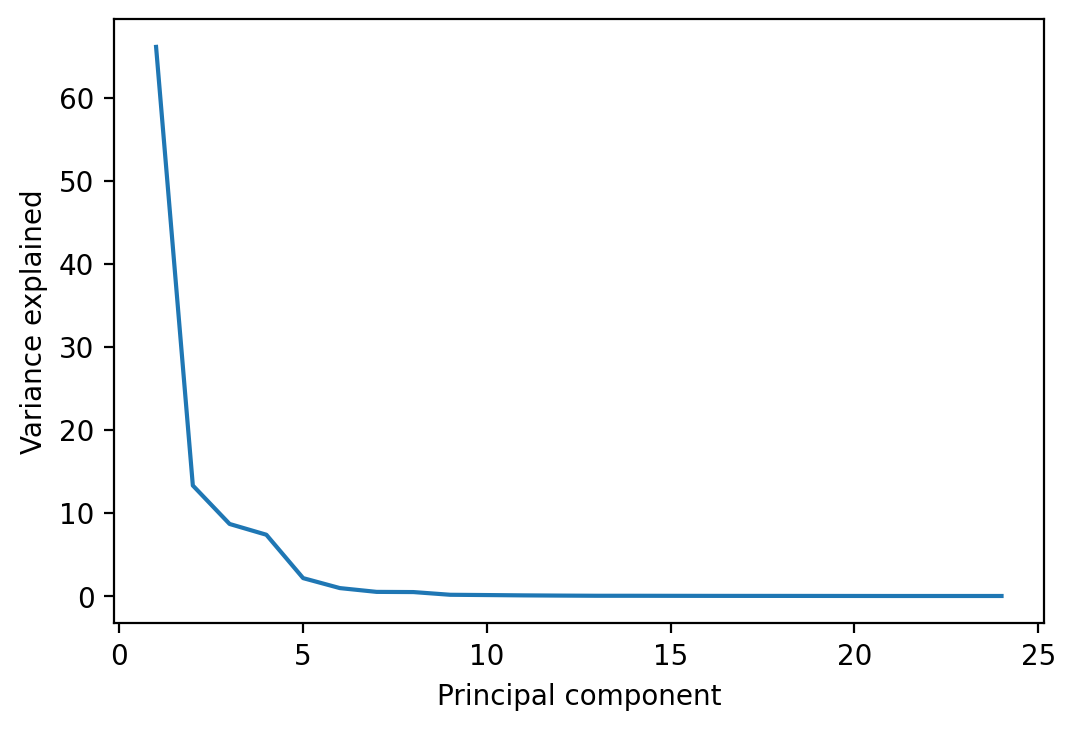

In [29]:
tangent_vectors=np.zeros((len(complex_preshapes),2*N))
for i in range(len(complex_preshapes)):
    tangent_vector=logarithmMap(mean_shape_Frechet, complex_preshapes[i])
    tangent_vectors[i,:N]=tangent_vector.real
    tangent_vectors[i,N:]=tangent_vector.imag

tangent_plane_pca = PCA()
transformed_vectors = tangent_plane_pca.fit_transform(tangent_vectors)

plt.plot(np.linspace(1,tangent_plane_pca.n_components_,tangent_plane_pca.n_components_),100*tangent_plane_pca.explained_variance_/np.sum(tangent_plane_pca.explained_variance_))
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.show()

**3.2** The lines below retreive the four first modes of shape variation and visualize them around the mean. What does it tell you about the shapes present in the data?

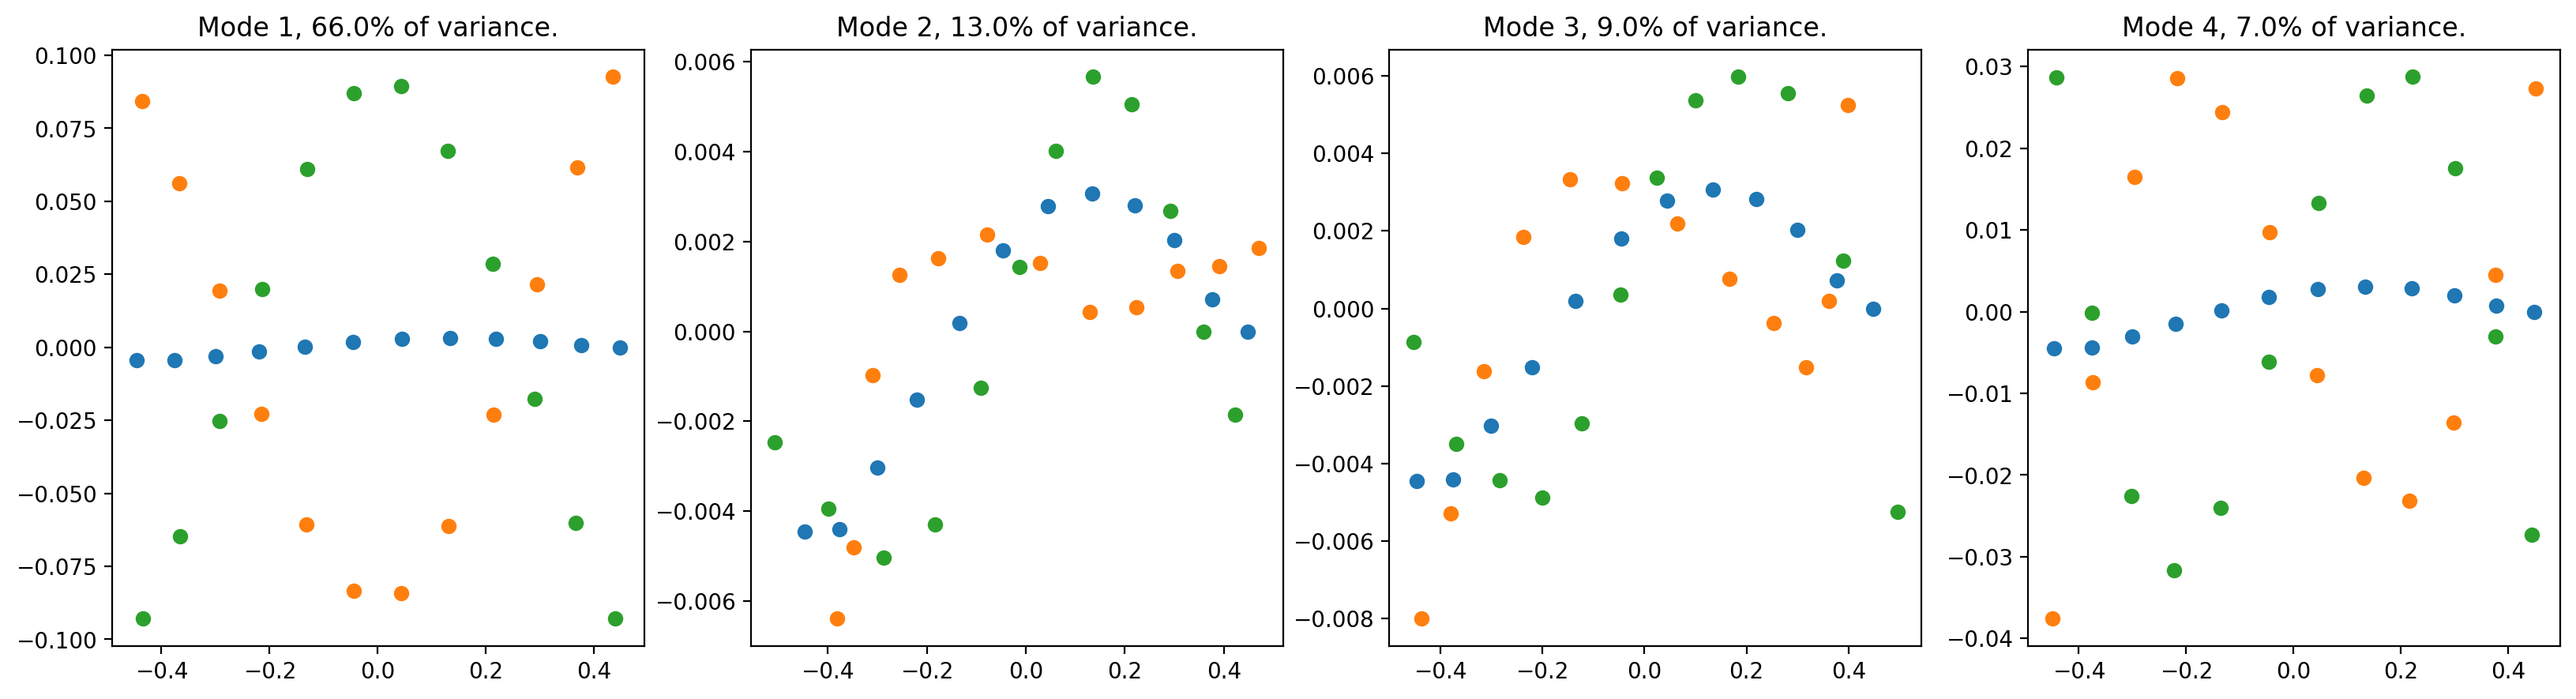

In [30]:
l=np.sqrt(tangent_plane_pca.explained_variance_)
K=4

modes_shape=np.zeros((K,2,N),dtype=complex)
for i in range(K) :
    vector=np.zeros(tangent_plane_pca.n_components_)
    vector[i]=1
    mode=l[i]*tangent_plane_pca.inverse_transform(vector)
    complex_mode=mode[:N]+1j*mode[N:]
    modes_shape[i][0]=exponentialMap(mean_shape_Frechet, complex_mode)
    modes_shape[i][1]=exponentialMap(mean_shape_Frechet, -complex_mode)
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
    ax[i].scatter(modes_shape[i][0].real, modes_shape[i][0].imag)
    ax[i].scatter(modes_shape[i][1].real, modes_shape[i][1].imag)
    
    percent_variance=np.round(100*l[i]**2/np.sum(tangent_plane_pca.explained_variance_))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance)+"% of variance.")

**3.3** The lines below plot the PCA-transformed data around the Fréchet mean. Each point corresponds to an object. If z_m is the Fréchet mean and l_1, l_2 are the two first eigenvalues of the PCA, the red point corresponds to z_m, the blue points to z_m +/- l_1, and the cyan point to z_m +/- l_2.

What does this plot tell you about the dataset?

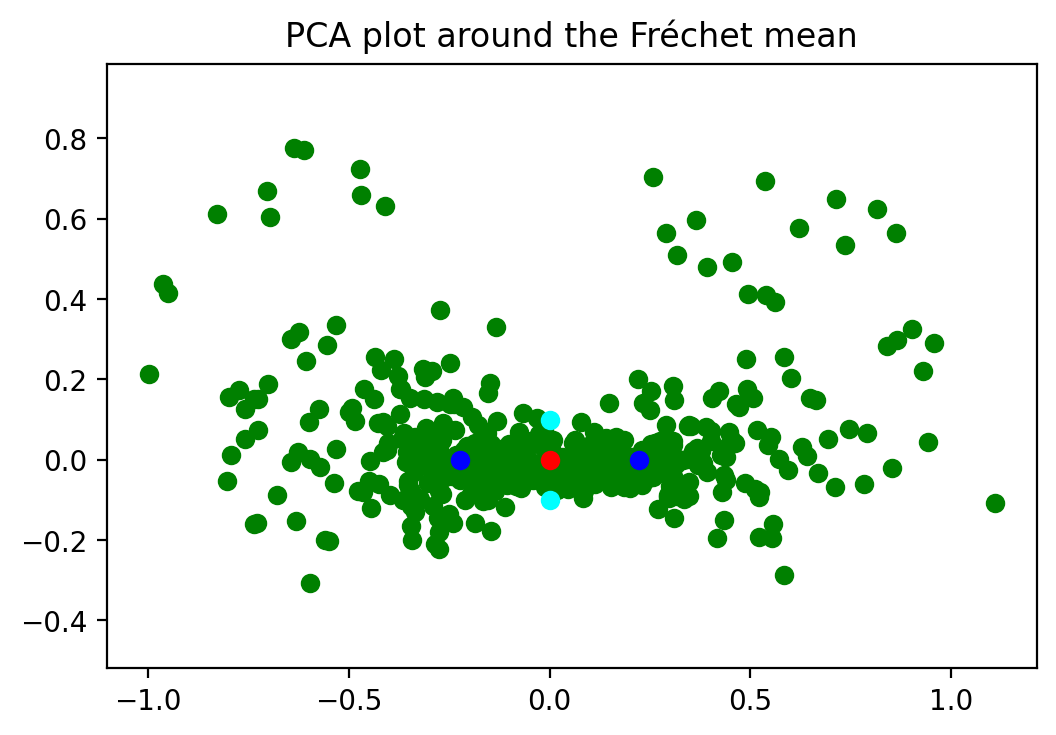

In [31]:
plt.scatter(transformed_vectors[:,0], transformed_vectors[:,1], c="g")
plt.scatter([0],[0], c="r")
plt.scatter([l[0],-l[0]], [0.,0.],c="blue")
plt.scatter([0.,0.],[l[1],-l[1]],c="cyan")
plt.axis("equal")
plt.title("PCA plot around the Fréchet mean")
plt.show()

**[BONUS] 3.4** The lines below perform PCA as above but without using the logarithm and exponential maps. What do you see? Can you relate that to what you observed in 2.7-2.8?

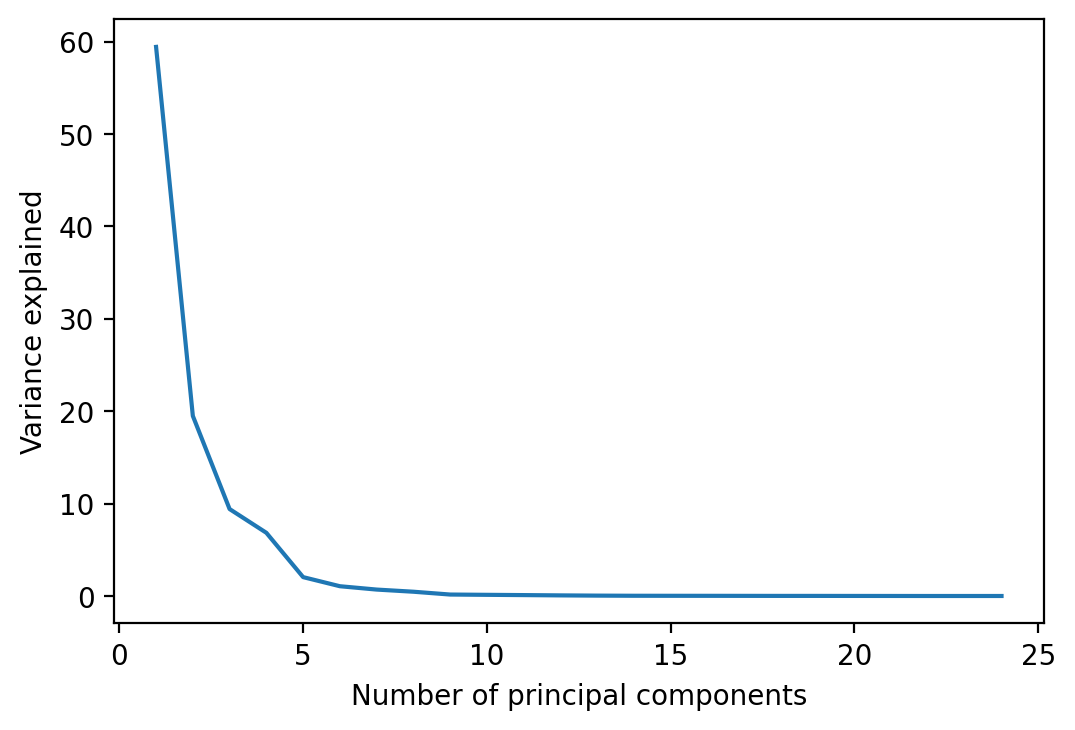

In [32]:
# Performs PCA assuming the shape space is linear
flattened_aligned_shapes=np.zeros((len(complex_aligned_shapes),2*N))
for i in range(len(complex_aligned_shapes)):
    flattened_aligned_shapes[i,:N]=complex_aligned_shapes[i].real
    flattened_aligned_shapes[i,N:]=complex_aligned_shapes[i].imag
    
flat_pca = PCA()
flat_transformed_data = flat_pca.fit_transform(flattened_aligned_shapes)

plt.plot(np.linspace(1,flat_pca.n_components_,flat_pca.n_components_),100*flat_pca.explained_variance_/np.sum(flat_pca.explained_variance_))
plt.xlabel("Number of principal components")
plt.ylabel("Variance explained")
plt.show()

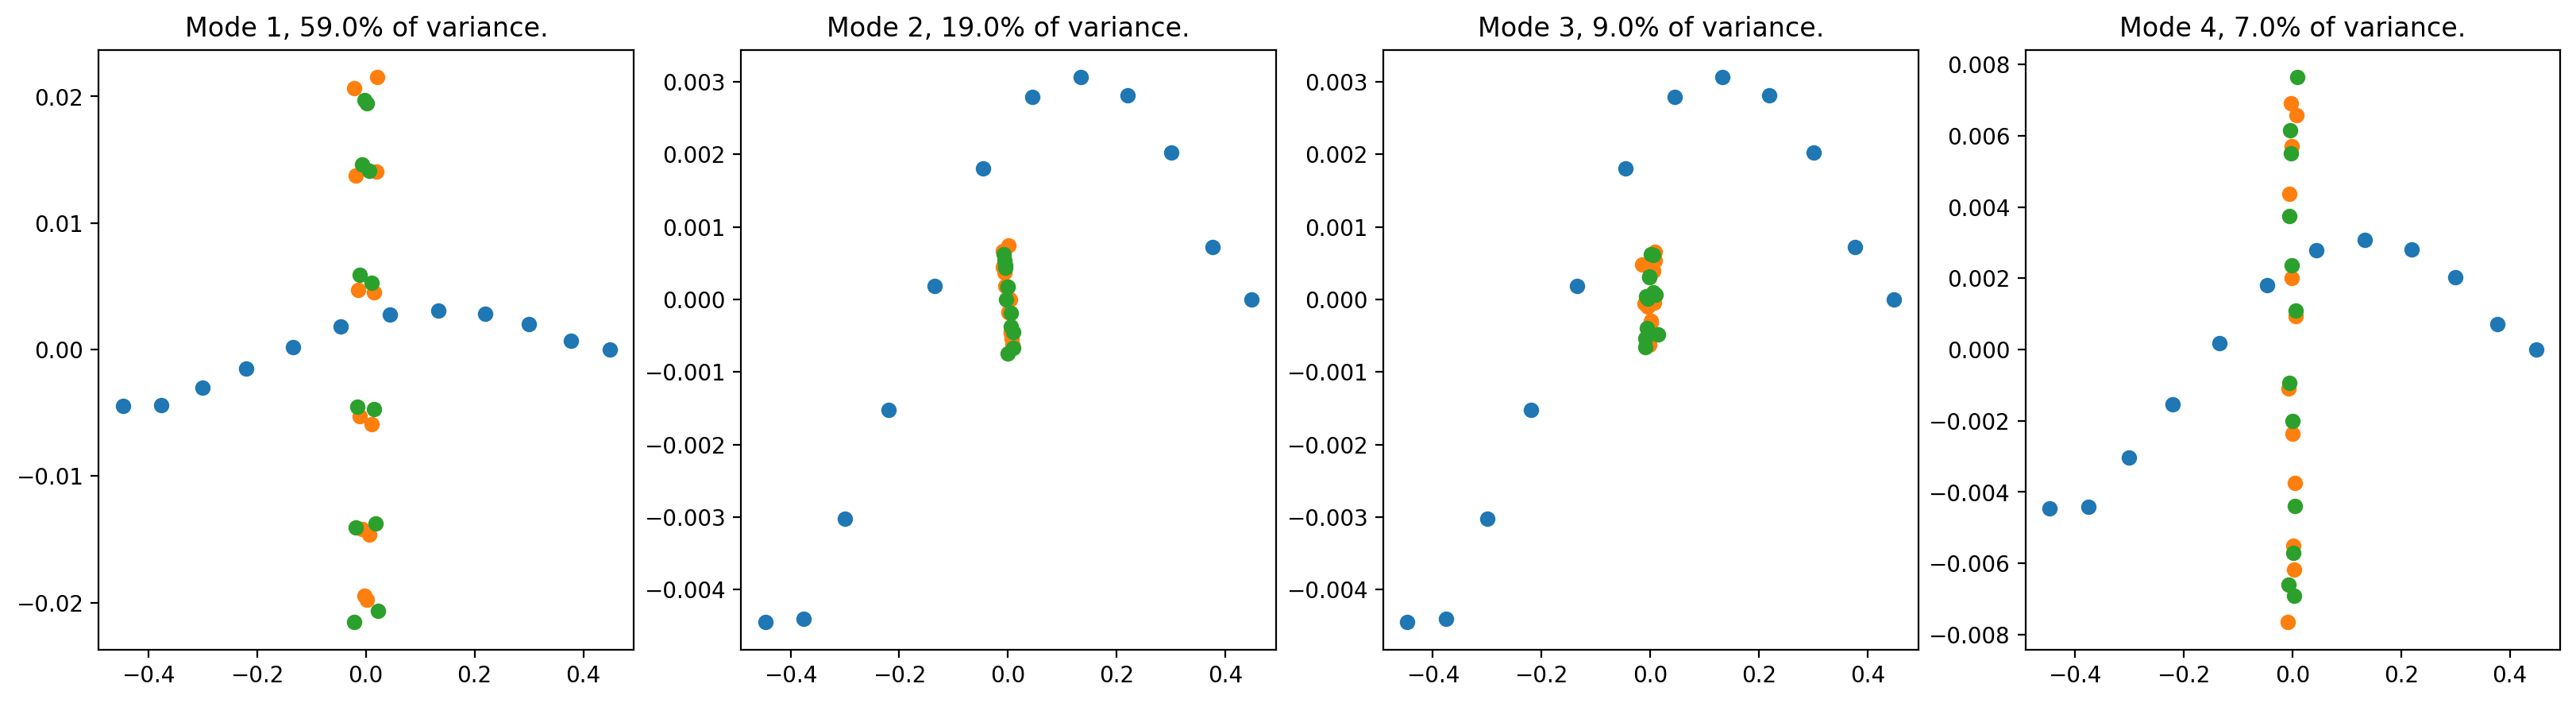

In [33]:
# Visualizes the first K modes of variation
flat_l=np.sqrt(flat_pca.explained_variance_)
K=4

flat_modes_shape=np.zeros((K,N,2))
for i in range(K) :
    vector=np.zeros(flat_pca.n_components_)
    vector[i]=1
    flat_mode=0.25*flat_l[i]*flat_pca.inverse_transform(vector)
    flat_modes_shape[i][:,0]=flat_mode[:N]
    flat_modes_shape[i][:,1]=flat_mode[N:]
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
    ax[i].scatter(flat_modes_shape[i][:,0], flat_modes_shape[i][:,1])
    ax[i].scatter(-flat_modes_shape[i][:,0], -flat_modes_shape[i][:,1])
    
    percent_variance=np.round(100*flat_l[i]**2/np.sum(flat_pca.explained_variance_))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance)+"% of variance.")

### 4. Shape space PCA on classes

We actually know that the shape distribution is bimodal, because there are dead and alive worms. To have a clearer picture of shape variability, we can thus carry out shape PCA on each class individually.

**4.1** Run the lines below to split the dataset into a collection of alive and a collection of dead C. elegans samples.  

In [34]:
label_data='data/C. elegans/labels.npy'
labels=np.load(label_data)

In [35]:
complex_preshapes_dead=complex_preshapes[np.where(labels==0)]
complex_preshapes_live=complex_preshapes[np.where(labels==1)]

**4.2** Run the lines below to visualize a set of a few randomly selected models from each collection.

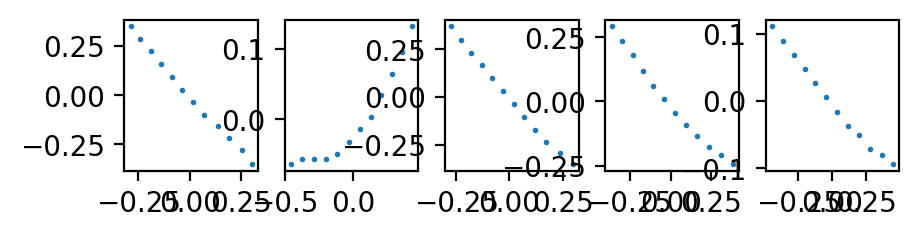

In [36]:
# Dead C. elegans
number=5
inds=np.random.choice(len(complex_preshapes_dead)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(number):
    sample=complex_preshapes_dead[inds[i]]
    ax[i].scatter(sample.real,sample.imag,s=1)

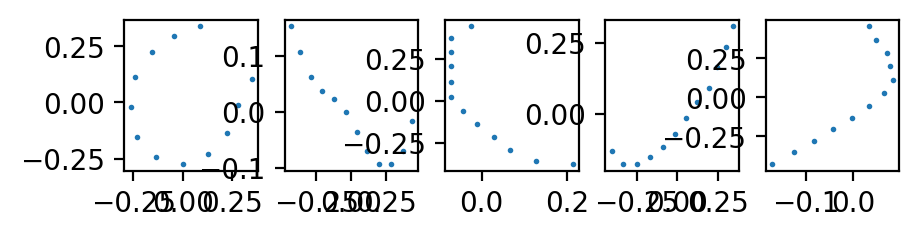

In [37]:
# Live C. elegans
number=5
inds=np.random.choice(len(complex_preshapes_live)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(number):
    sample=complex_preshapes_live[inds[i]]
    ax[i].scatter(sample.real,sample.imag,s=1)

**4.3** Compute and visualize the Fréchet mean for each individual class, reusing the `meanFrechet` function from 2.2. How do they differ from what you got in 2.2?

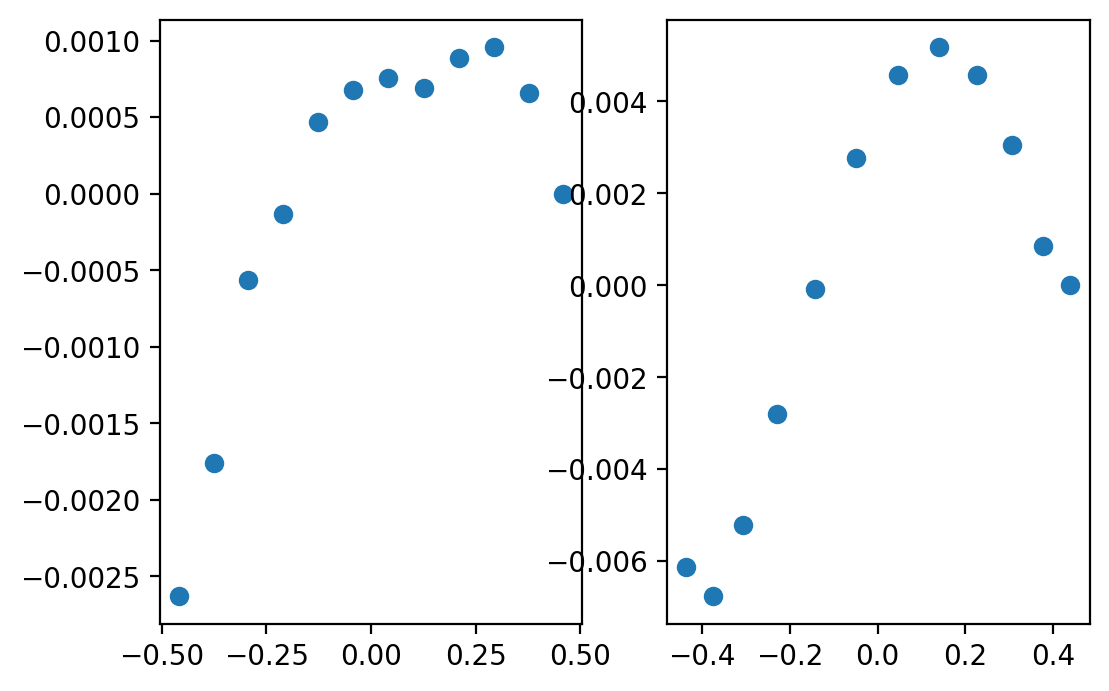

In [38]:
# Solution:
mean_shape_Frechet_dead=meanFrechet(complex_preshapes_dead)
mean_shape_Frechet_live=meanFrechet(complex_preshapes_live)

fig, ax = plt.subplots(1,2)
ax[0].scatter(mean_shape_Frechet_dead.real,mean_shape_Frechet_dead.imag)
ax[1].scatter(mean_shape_Frechet_live.real,mean_shape_Frechet_live.imag)
plt.show()

**4.4** For each class, perform PCA in the tangent plane around the Fréchet mean by adapting the code from 3.1.

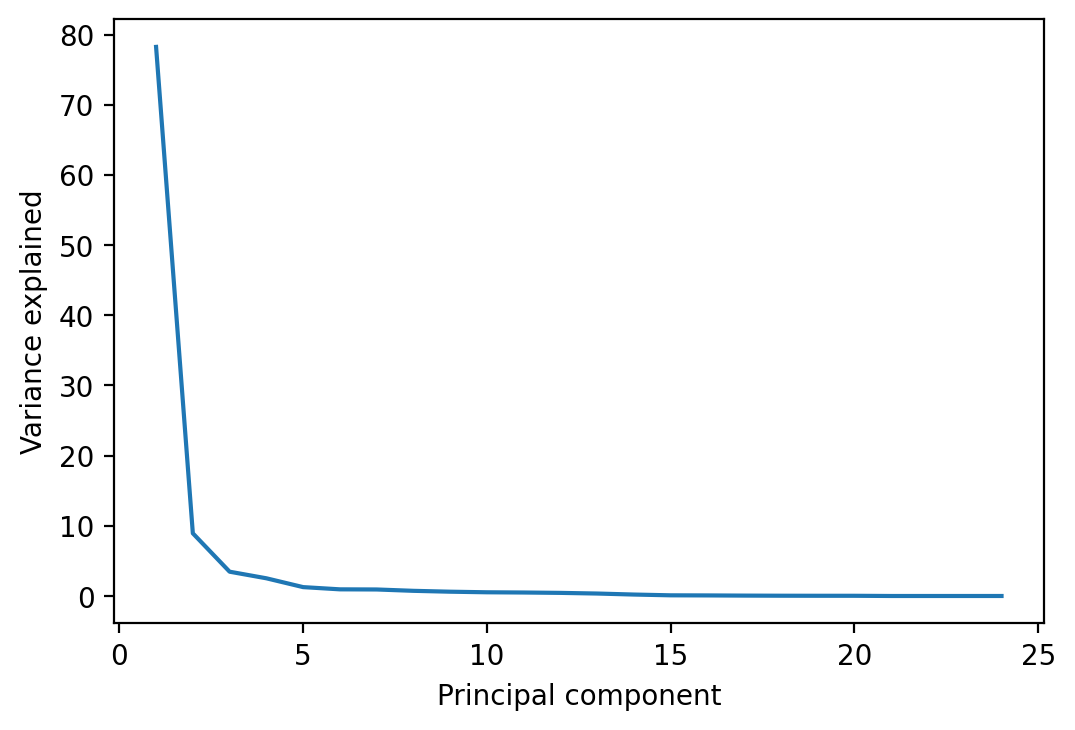

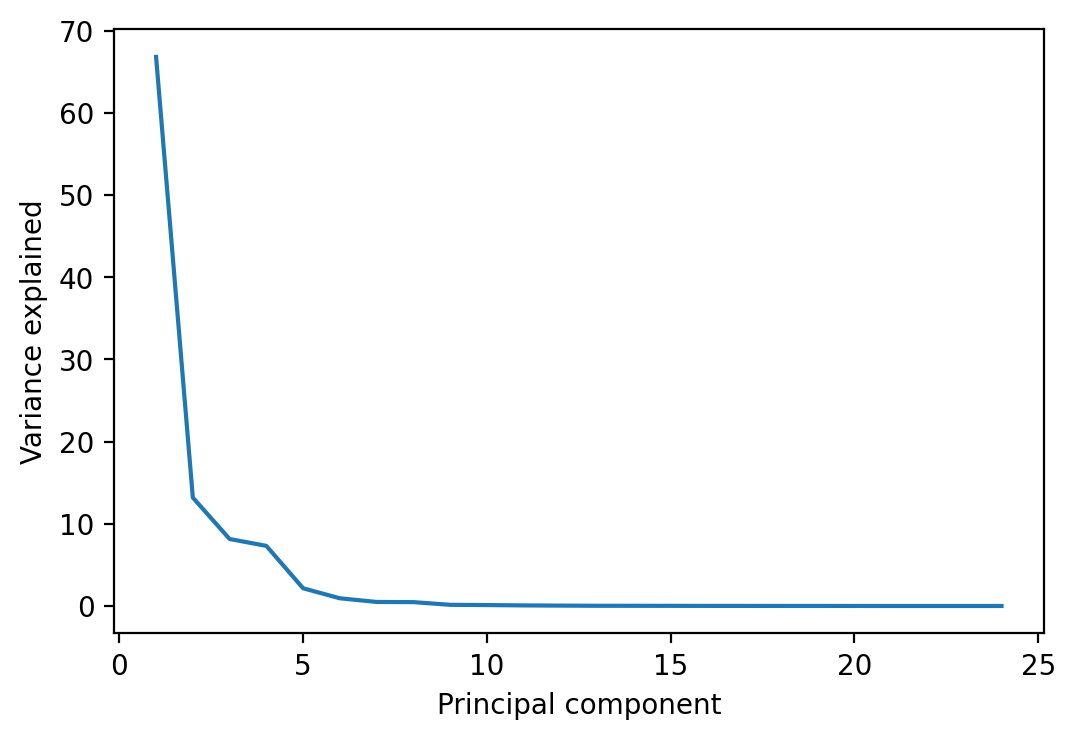

In [39]:
# Solution:
# Dead C. elegans
tangent_vectors_dead=np.zeros((len(complex_preshapes_dead),2*N))
for i in range(len(complex_preshapes_dead)):
    tangent_vector_dead=logarithmMap(mean_shape_Frechet_dead, complex_preshapes_dead[i])
    tangent_vectors_dead[i,:N]=tangent_vector_dead.real
    tangent_vectors_dead[i,N:]=tangent_vector_dead.imag

tangent_plane_pca_dead = PCA()
transformed_vectors_dead = tangent_plane_pca_dead.fit_transform(tangent_vectors_dead)

fig, ax = plt.subplots(1,1)
ax.plot(np.linspace(1,tangent_plane_pca_dead.n_components_,tangent_plane_pca_dead.n_components_),100*tangent_plane_pca_dead.explained_variance_/np.sum(tangent_plane_pca_dead.explained_variance_))
ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained")
plt.show()

# Live C. elegans
tangent_vectors_live=np.zeros((len(complex_preshapes_live),2*N))
for i in range(len(complex_preshapes_live)):
    tangent_vector_live=logarithmMap(mean_shape_Frechet_live, complex_preshapes_live[i])
    tangent_vectors_live[i,:N]=tangent_vector_live.real
    tangent_vectors_live[i,N:]=tangent_vector_live.imag

tangent_plane_pca_live = PCA()
transformed_vectors_live = tangent_plane_pca_live.fit_transform(tangent_vectors_live)

fig, ax = plt.subplots(1,1)
ax.plot(np.linspace(1,tangent_plane_pca_live.n_components_,tangent_plane_pca_live.n_components_),100*tangent_plane_pca_live.explained_variance_/np.sum(tangent_plane_pca_live.explained_variance_))
ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained")
plt.show()

**4.5** For each class, retreive the two first modes of shape variation and visualize them around the mean by adapting the code from 3.2. How do they differ from what you got in 3.2?

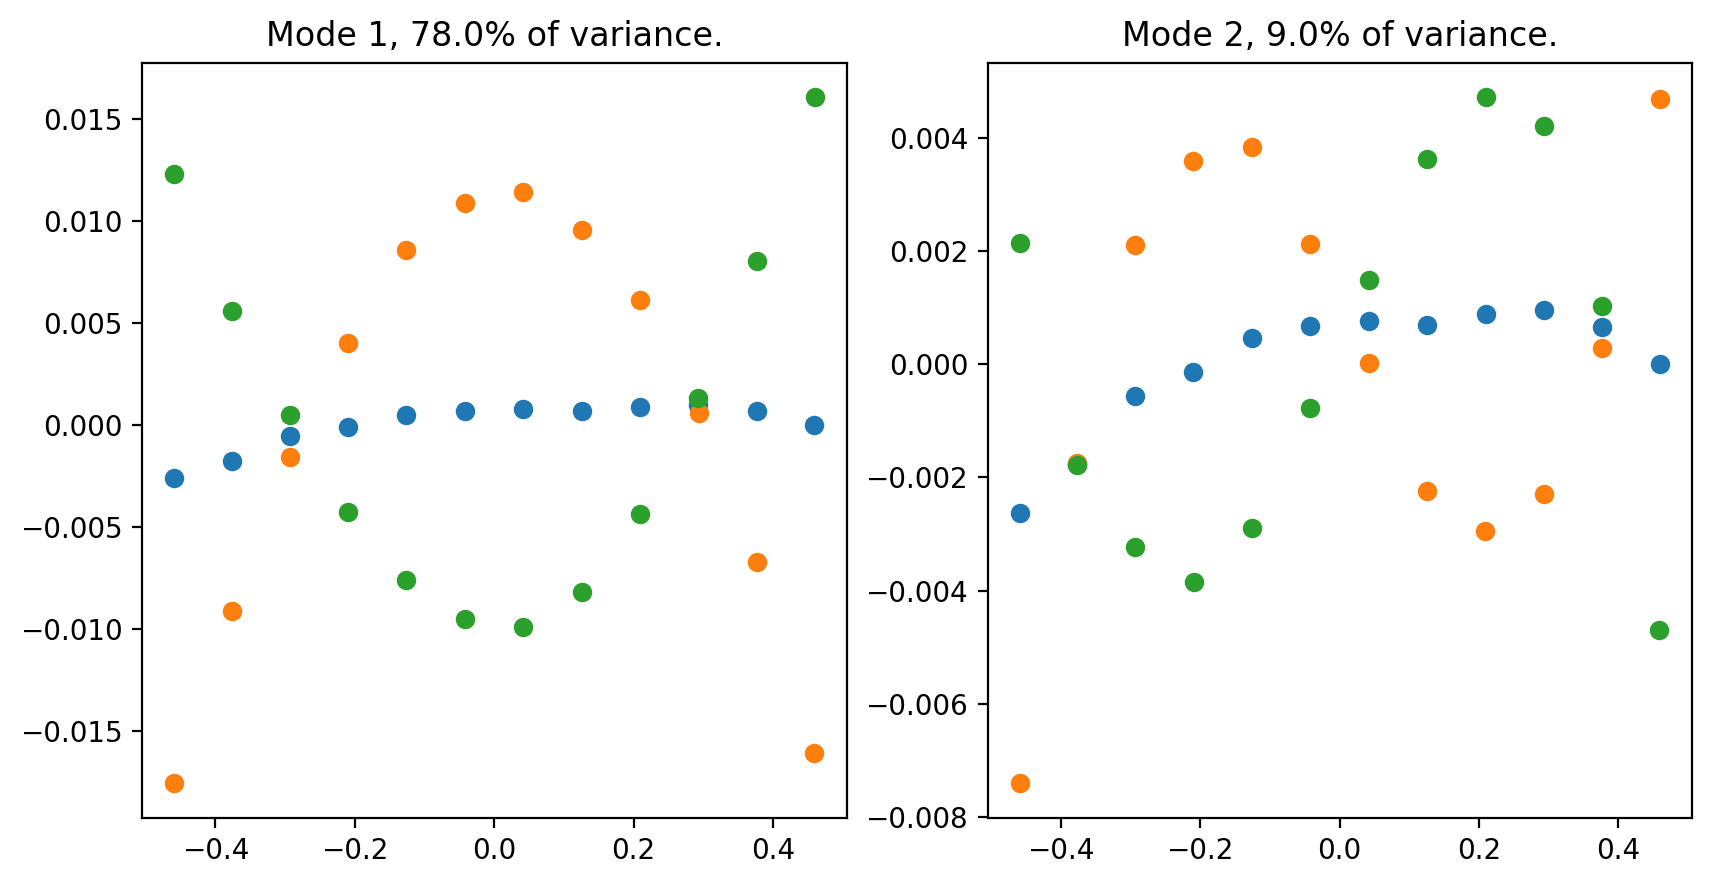

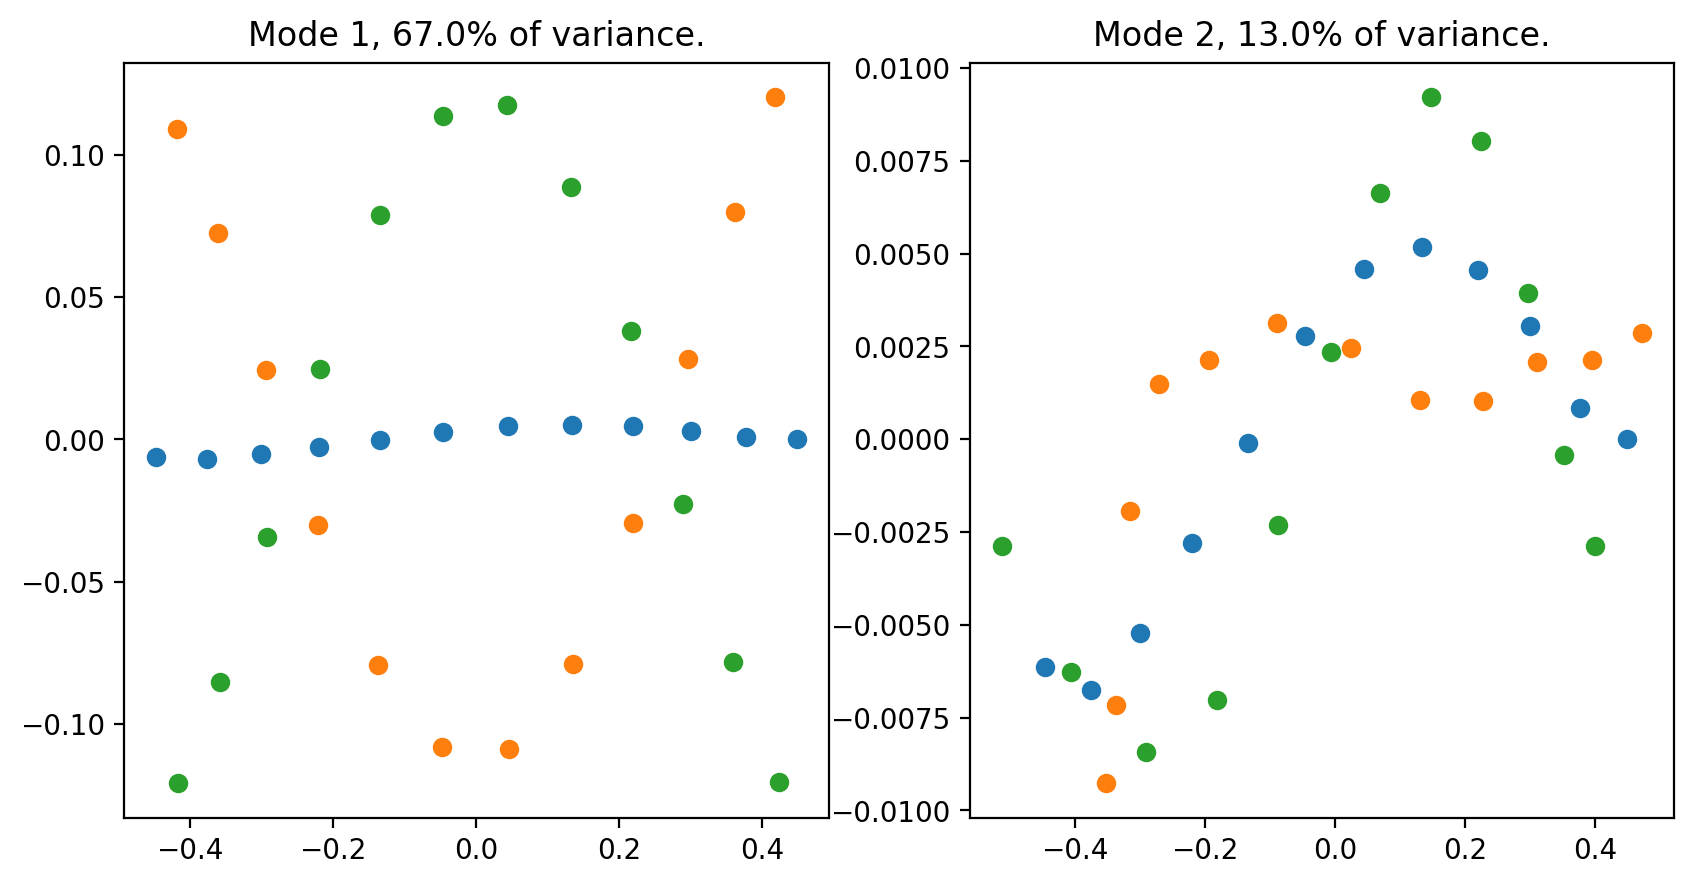

In [40]:
# Solution:
K=2

# Dead C. elegans
l_dead=np.sqrt(tangent_plane_pca_dead.explained_variance_)

modes_shape_dead=np.zeros((K,2,N),dtype=complex)
for i in range(K) :
    vector=np.zeros(tangent_plane_pca_dead.n_components_)
    vector[i]=1
    mode=l_dead[i]*tangent_plane_pca_dead.inverse_transform(vector)
    complex_mode=mode[:N]+1j*mode[N:]
    modes_shape_dead[i][0]=exponentialMap(mean_shape_Frechet_dead, complex_mode)
    modes_shape_dead[i][1]=exponentialMap(mean_shape_Frechet_dead, -complex_mode)
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet_dead.real,mean_shape_Frechet_dead.imag)
    ax[i].scatter(modes_shape_dead[i][0].real, modes_shape_dead[i][0].imag)
    ax[i].scatter(modes_shape_dead[i][1].real, modes_shape_dead[i][1].imag)
    
    percent_variance_dead=np.round(100*l_dead[i]**2/np.sum(tangent_plane_pca_dead.explained_variance_))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance_dead)+"% of variance.")
    
# Live C. elegans   
l_live=np.sqrt(tangent_plane_pca_live.explained_variance_)

modes_shape_live=np.zeros((K,2,N),dtype=complex)
for i in range(K) :
    vector=np.zeros(tangent_plane_pca_live.n_components_)
    vector[i]=1
    mode=l_live[i]*tangent_plane_pca_live.inverse_transform(vector)
    complex_mode=mode[:N]+1j*mode[N:]
    modes_shape_live[i][0]=exponentialMap(mean_shape_Frechet_live, complex_mode)
    modes_shape_live[i][1]=exponentialMap(mean_shape_Frechet_live, -complex_mode)
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet.real,mean_shape_Frechet_live.imag)
    ax[i].scatter(modes_shape_live[i][0].real, modes_shape_live[i][0].imag)
    ax[i].scatter(modes_shape_live[i][1].real, modes_shape_live[i][1].imag)
    
    percent_variance_live=np.round(100*l_live[i]**2/np.sum(tangent_plane_pca_live.explained_variance_))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance_live)+"% of variance.")

**4.6** The lines below plot the PCA-transformed data around the Fréchet mean for each class (see 3.3 for a detailed explanations of what the different coloured points correspond to). How does it compare to 3.3?

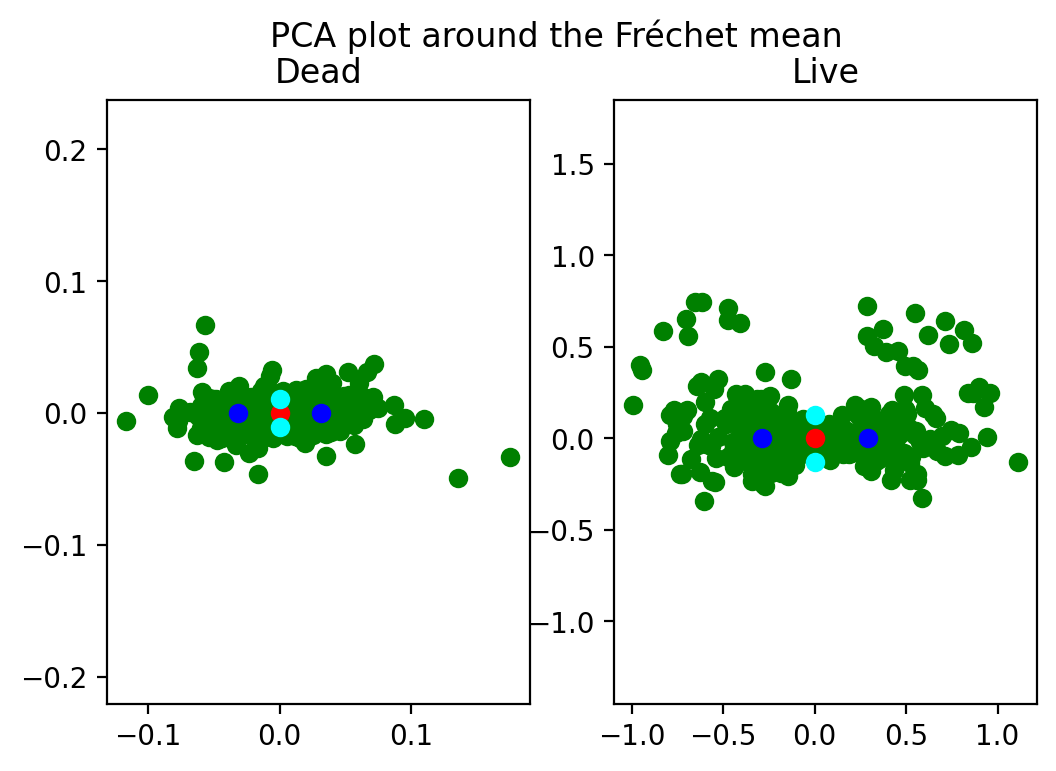

In [41]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(transformed_vectors_dead[:,0], transformed_vectors_dead[:,1], c="g")
ax[0].scatter([0],[0], c="r")
ax[0].scatter([l_dead[0],-l_dead[0]], [0.,0.],c="blue")
ax[0].scatter([0.,0.],[l_dead[1],-l_dead[1]],c="cyan")
ax[0].axis("equal")
ax[0].set_title("Dead")

ax[1].scatter(transformed_vectors_live[:,0], transformed_vectors_live[:,1], c="g")
ax[1].scatter([0],[0], c="r")
ax[1].scatter([l_live[0],-l_live[0]], [0.,0.],c="blue")
ax[1].scatter([0.,0.],[l_live[1],-l_live[1]],c="cyan")
ax[1].axis("equal")
ax[1].set_title("Live")

plt.suptitle("PCA plot around the Fréchet mean")
plt.show()

### 5. Statistical shape modelling

**5.1** The following lines generate synthetic live C. elegans shapes relying on a simple statistical model (multivariate Gaussian) built from the covariance matrix of the dataset. Do you understand how the model is constructed? How good do you think this model is and why?

In [42]:
import scipy.stats

In [43]:
count=3
num_synthetic_data=5

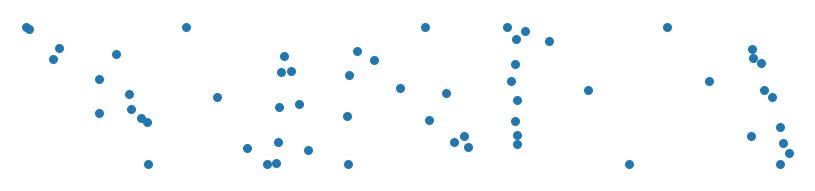

In [44]:
# Live C. elegans
synthetic_data_live=np.zeros((num_synthetic_data,N),dtype=complex)
for i in range(num_synthetic_data):
    rand=[]
    for k in range(tangent_plane_pca_live.n_components_):
        var=tangent_plane_pca_live.explained_variance_[k]*(len(tangent_vectors_live)-1)
        if var<1e-6:
            sigma=0.0
        else:
            sigma=np.sqrt(var)
        rand.append(scipy.stats.norm.rvs(loc=0, scale=sigma, size=1))
    rand=np.array(rand)

    v=np.zeros((tangent_plane_pca_live.n_components_))
    for k in range(count):
        zz=rand.T @ tangent_plane_pca_live.components_.T[:,k]
        v+=(zz*tangent_plane_pca_live.components_.T[:,k])
    v+=tangent_plane_pca_live.mean_
    
    complex_v=v[:N]+1j*v[N:]
    synthetic_data_live[i]=exponentialMap(mean_shape_Frechet_live, complex_v) 
    
fig, ax = plt.subplots(1, num_synthetic_data, figsize=(num_synthetic_data,1))
for i in range(num_synthetic_data):
    ax[i].scatter(synthetic_data_live[i].real, synthetic_data_live[i].imag, s=5)
    ax[i].axis("off")